# What am I Investigating?
Tennis is a racquet sport that can be played individually against a single opponent (singles) or between two teams of two players each (doubles). Players use a strung racquet to strike a hollow rubber ball, covered with felt, over a net and into the opponent's court. The objective of the game is to play the ball in such a way that the opponent cannot play a valid return. The player who is unable to return the ball will not gain a point, while the opposite player will.  
Tennis is played on different surfaces, including grass, clay, hard courts, and even indoor carpet. Each surface affects the ball's speed and bounce differently, leading to varied styles of play.  
*I'm intrested to find out if there's a relationship between the surface the match was played on and its duration*.

# Importing Libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

pd.set_option('display.max_columns', 50)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [ ]:
combined_df.sample(10)

# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [4]:
number_of_rows_pre_cleaning = combined_df.shape[0]
number_of_columns_pre_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_pre_cleaning} rows and {number_of_columns_pre_cleaning} columns.")

The dataset has 104682 rows and 49 columns.


Counting the number of NA's in each column:

In [ ]:
combined_df.isna().sum()

Checking if there are any duplicate rows:

In [6]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

Deleting matches that we don't know their statistics:

In [7]:
# Creating a list of columns names that has the statistics
match_data_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

# Dropping all the rows based on the subset of columns in the list above
combined_df.dropna(subset=match_data_columns_names, inplace=True)

# Checking if it worked
combined_df[match_data_columns_names].isna().sum()

w_ace        0
w_df         0
w_svpt       0
w_1stIn      0
w_1stWon     0
w_2ndWon     0
w_SvGms      0
w_bpSaved    0
w_bpFaced    0
l_ace        0
l_df         0
l_svpt       0
l_1stIn      0
l_1stWon     0
l_2ndWon     0
l_SvGms      0
l_bpSaved    0
l_bpFaced    0
dtype: int64

Deleting unnecessary columns:

In [ ]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"]

combined_df.drop(columns=names_of_columns_to_drop, inplace=True)

combined_df.columns

Getting the number of rows and columns in the dataset (post-cleaning):

In [ ]:
number_of_rows_post_cleaning = combined_df.shape[0]
number_of_columns_post_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_post_cleaning} rows and {number_of_columns_post_cleaning} columns.")
print(f"{number_of_rows_pre_cleaning-number_of_rows_post_cleaning} rows were deleted and {number_of_columns_pre_cleaning-number_of_columns_post_cleaning} were removed.")

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [ ]:
combined_df['tourney_date'] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df['tourney_date'].head()

Creating new columns:

In [ ]:
# Creating a variable called "total_points" - the total points played in the match.
combined_df["total_points"] = combined_df["w_svpt"]+combined_df["l_svpt"]

combined_df.sample(7)

# Univariate Analysis

## Categorical Variables

Counting the number of games played on each surface type (and plotting it):

In [ ]:
combined_df.surface.value_counts()

Hard      47729
Clay      31085
Grass      9783
Carpet     5878
Name: surface, dtype: int64

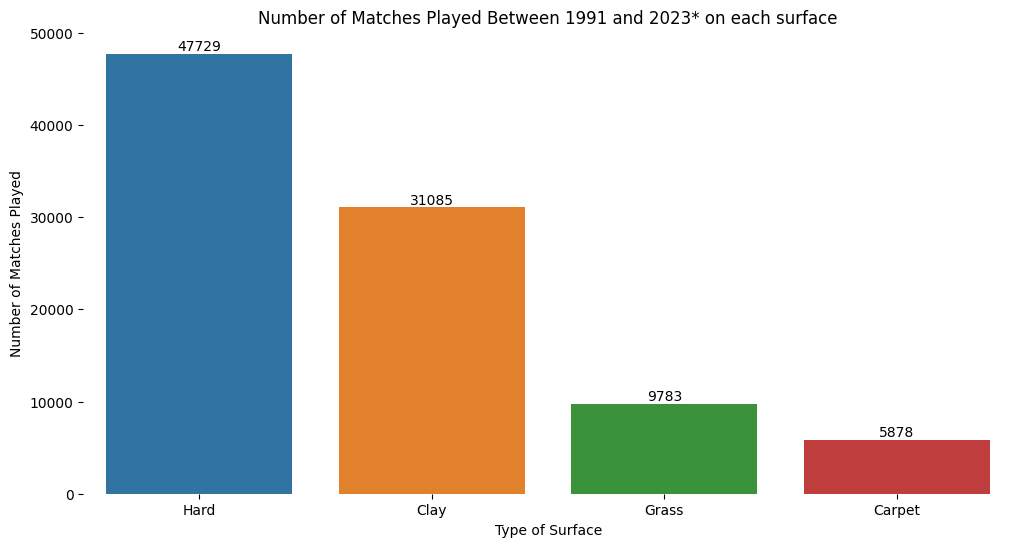

In [17]:
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)
sns.despine(left=True, bottom=True)
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")
plt.show()

Counting the number of times a best of 3 sets and a best of 5 sets were played (and plotting it):

In [18]:
combined_df.best_of.value_counts()

3    77549
5    16926
Name: best_of, dtype: int64

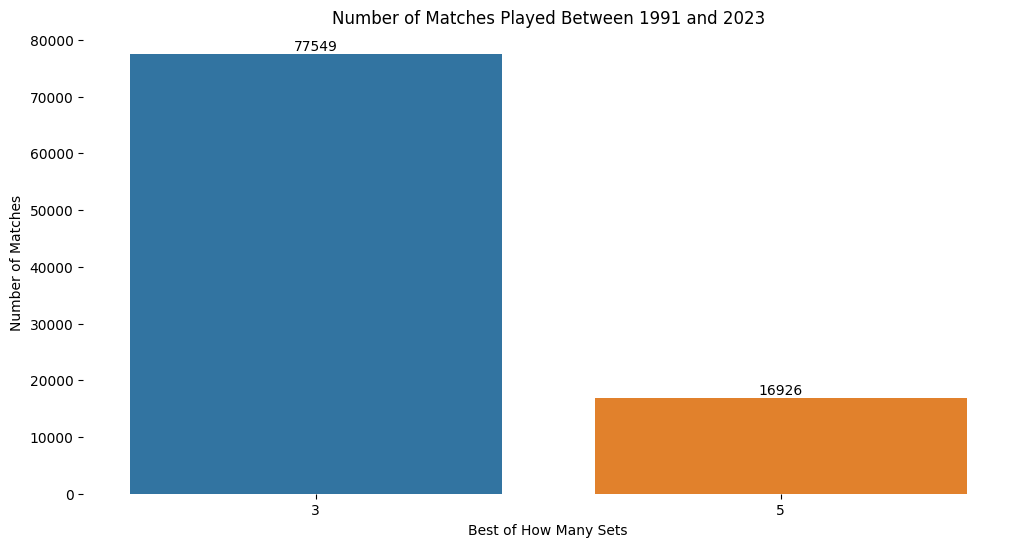

In [38]:
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)
sns.despine(left=True, bottom=True)
best_of_countplot.bar_label(best_of_countplot.containers[0], label_type='edge')
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")
plt.show()

In [ ]:
combined_df.winner_hand.value_counts()

In [ ]:
combined_df.loser_hand.value_counts()

## Numerical Variables

### Analyzing the total_points variable:

In [ ]:
combined_df.total_points.describe()

In [ ]:
total_points_skewness = combined_df.total_points.skew()
total_points_kurtosis = combined_df.total_points.kurtosis()

print(f"Skewness: {round(total_points_skewness, 3)}")
print(f"Kurtosis: {round(total_points_kurtosis, 3)}")

In [ ]:
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")
sns.despine(left=True, bottom=True)
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")
plt.show()

### Analyzing the winner_age variable:

In [14]:
combined_df["winner_age"].describe()

count    94475.000000
mean        25.894353
std          3.792666
min         14.900000
25%         23.100000
50%         25.600000
75%         28.400000
max         42.700000
Name: winner_age, dtype: float64

In [45]:
winner_age_skewness = combined_df["winner_age"].skew()
winner_age_kurtosis = combined_df["winner_age"].kurtosis()

print(f"Skewness: {round(winner_age_skewness, 3)}")
print(f"Kurtosis: {round(winner_age_kurtosis, 3)}")

Skewness: 0.413
Kurtosis: -0.092


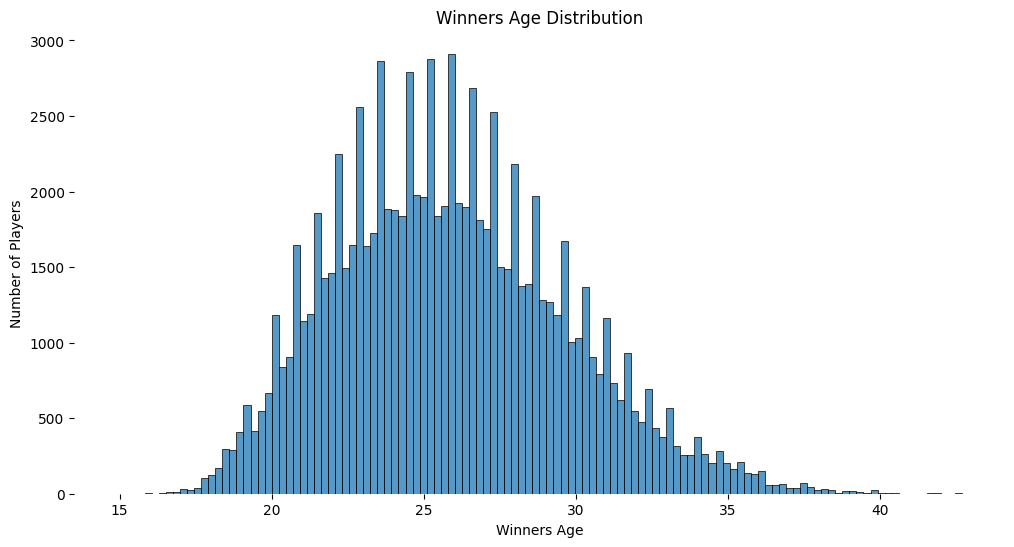

In [16]:
plt.figure(figsize=(12, 6))
winner_age_histogram = sns.histplot(data=combined_df, x="winner_age")
sns.despine(left=True, bottom=True)
winner_age_histogram.set_xlabel("Winners Age")
winner_age_histogram.set_ylabel("Number of Players")
winner_age_histogram.set_title("Winners Age Distribution")
plt.show()